# Linear Models - Annotate RS-PCA-Components

This notebook mainly contains:<br>
(1) Collection and preprocessing of diverse brain organization group-levle reference maps<br>
(2) General annotation of all 200 Group-Level RS-PCA-Components with the reference maps<br>
(3) Task contrast specific annotation of most predictive RS-PCA components<br>

**Inputs**
Linear model weights for the PCA components<br>
`results/scores/rs_pca.lin_weights.200.spatial_zscore.yfull.npy`

(alternatively the component importance values derived by feature-pertubation analysis)<br>
`results/scores/rs_pca.lin_weight_onebyone_contrib.values.diff.spatial_zscore.yresid.npy`

group pca components (to which all indiviudal pca components had been aligned)<br>
`data/group_conmat_pca.200c.pkl`


**Outputs**

All the collected cortical reference maps<br>
`data/all_cortical_reference_maps.fslr32k.l29.npy`

General component annotations (saved as xls)<br>
`annotate_rs_components.xlsx`

Per task component annotation (inline in the notebook)<br>

In [1]:
import torch
import numpy as np
import scipy
from tqdm import tqdm
import os, brainspace

from lib.stats import np_pearson_cor

#import sys
#sys.path.append("/home/mpg02/MLSC/robert.scholz2/.local/lib/python3.7/site-packages")

from brainspace.utils.parcellation  import map_to_labels, reduce_by_labels

# plotting libraries
from matplotlib import pyplot as plt

from lib.plotting import plot_29k
import hcp_utils as hcp

def pearson_correlation(mapset1, mapset2):
    corrs = np.zeros((len(mapset1), len(mapset2)));
    for i, map1 in enumerate(mapset1):
        for j, map2 in enumerate(mapset2):
            c = np.vstack([map1,map2])
            d = c[:,~np.any(np.isnan(c), axis=0)]
            r,p= scipy.stats.mstats.pearsonr(d[0],d[1])
            #r= np_pearson_cor(d[0],d[1])
            corrs[i,j] =r
    return corrs



unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]
cids = contrast_ids_to_show

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# Collect all reference maps in 29k space

Each of the subsections will append to the following two array:
* `cmaps - group level brain feature maps (projected) in(to) fslr29K left hemisphere space`
* `cnames - containing the names of the brain feature maps`


## HCP Networks

In [7]:
ymaps = []
ynames = []

parcellations = [hcp.yeo7["map_all"], hcp.yeo17["map_all"], hcp.ca_network["map_all"]]
label_lists = [list(p["labels"].values()) for p in [hcp.yeo7, hcp.yeo17, hcp.ca_network]]
prefixes = ["yeo7_", "yeo17_", "ca_"];
for parcell, labales, pref in zip(parcellations, label_lists, prefixes):
    for i in np.unique(parcell):
       map_name = labales[i]
       if map_name!="":
         ymaps.append((parcell==i).astype(int)[slice(0,29696)])
         ynames.append(pref+ map_name)
         #print(map_name, maps[-1].shape)

ymaps = np.array(ymaps)
print(len(ynames), ymaps.shape, "\n", ynames)#pca.components_.shape, "\n", ynames)

36 (36, 29696) 
 ['yeo7_Visual', 'yeo7_Somatomotor', 'yeo7_Dorsal Attention', 'yeo7_Ventral Attention', 'yeo7_Limbic', 'yeo7_Frontoparietal', 'yeo7_Default', 'yeo17_network_1', 'yeo17_network_2', 'yeo17_network_3', 'yeo17_network_4', 'yeo17_network_5', 'yeo17_network_6', 'yeo17_network_7', 'yeo17_network_8', 'yeo17_network_9', 'yeo17_network_10', 'yeo17_network_11', 'yeo17_network_12', 'yeo17_network_13', 'yeo17_network_14', 'yeo17_network_15', 'yeo17_network_16', 'yeo17_network_17', 'ca_Visual1', 'ca_Visual2', 'ca_Somatomotor', 'ca_Cingulo-Opercular', 'ca_Dorsal-attention', 'ca_Language', 'ca_Frontoparietal', 'ca_Auditory', 'ca_Default', 'ca_Posterior-Multimodal', 'ca_Ventral-Multimodal', 'ca_Orbito-Affective']


In [8]:
hcp.yeo7["labels"]

{0: '',
 1: 'Visual',
 2: 'Somatomotor',
 3: 'Dorsal Attention',
 4: 'Ventral Attention',
 5: 'Limbic',
 6: 'Frontoparietal',
 7: 'Default'}

## Gene maps (Dear)

In [9]:
# add gene maps 
# Three components of human brain gene expression reflect normative developmental programmes with specific links to neurodevelopmental disorders
# https://github.com/richardajdear/AHBA_gradients/blob/master/outputs/ahba_dme_hcp_top8kgenes_scores.csv
# https://github.com/richardajdear/AHBA_gradients/tree/master/data

!wget https://raw.githubusercontent.com/richardajdear/AHBA_gradients/master/outputs/ahba_dme_hcp_top8kgenes_scores.csv -O data/misc/ahba_dme_hcp_top8kgenes_scores.csv
!wget https://raw.githubusercontent.com/richardajdear/AHBA_gradients/master/data/cortical_maps.csv -O data/misc/cortical_maps.csv
!ls data/misc

--2024-10-24 11:21:44--  https://raw.githubusercontent.com/richardajdear/AHBA_gradients/master/outputs/ahba_dme_hcp_top8kgenes_scores.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9144 (8.9K) [text/plain]
Saving to: 'data/misc/ahba_dme_hcp_top8kgenes_scores.csv'

data/misc/ahba_dme_ 100%[===================>]   8.93K  --.-KB/s    in 0s      

2024-10-24 11:21:44 (66.7 MB/s) - 'data/misc/ahba_dme_hcp_top8kgenes_scores.csv' saved [9144/9144]

--2024-10-24 11:21:45--  https://raw.githubusercontent.com/richardajdear/AHBA_gradients/master/data/cortical_maps.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.1

In [11]:
# load the per parcel data
import pandas as pd
gs = pd.read_csv("data/misc/ahba_dme_hcp_top8kgenes_scores.csv")
print("#Areas:", len(gs))
gs.head(3)

#Areas: 137


,id,C1,C2,C3,label
0,1,2.120108,-2.126559,-1.905905,V1
1,4,2.049858,-1.774576,-1.487738,V2
2,5,2.034841,-1.899119,-1.299373,V3


In [12]:
# Get the roi labels for the loaded data
gs_labels = np.array([s.lower() for s in gs["label"].to_numpy()])

In [13]:
## Get the corresponding parcellation 

# get the HCP MMP1 parcellation (roi labels, and vertex assignments) - left hemisphere
print(hcp.mmp.keys())
mmp_labels=[hcp.mmp.labels[l].split("_")[-1].lower() for l in range(181)][1:]
hcpmmpl = hcp.mmp["map_all"][:29696]

# count how many rois are existing for the gene data, and how many overall
# some labels seem to be missing
len(gs_labels), len(mmp_labels), len(np.unique(hcpmmpl))

## Check which arcels are missing which ones are missing
mask = np.array([(l in gs_labels) for l in mmp_labels])
print("Missing:", [l for l in mmp_labels if not(l in gs_labels)])
print("\nRemaining are in correct order:", end=" ")
print(np.all(np.array(mmp_labels)[mask.astype(bool)] == gs_labels))

dict_keys(['ids', 'map_all', 'labels', 'rgba', 'nontrivial_ids'])
Missing: ['mst', 'v6', 'v8', 'pef', 'v7', 'v3b', 'lo1', 'lo2', 'pit', 'mt', 'v23ab', '5m', '7pl', '6v', '47m', '10d', '6r', 'ifja', 'ifjp', 'a10p', '10pp', 'lipd', 's6-8', 'op1', 'op2-3', 'ri', 'pfcm', 'pir', 'aaic', 'fop1', 'fop2', 'h', 'pros', 'stsda', 'tpoj3', 'v6a', 'v4t', 'v3cd', 'vmv2', 'fop5', 'p10p', 'lbelt', 'p24']

Remaining are in correct order: True


In [14]:
# map gene data to full 29k resolution
cmaps = []
cnames=[]

for c in ["C1", "C2", "C3"]:
   # create a vecor with fields for all of the 180 left hemispheric parcels of the HCPMMP1.0
   ndata = np.zeros(180)
    
   # get the values for the current gene component for the parcels covered
   gsc1 = gs[c].to_numpy() # (137,)
    
   # fill in the corrsponding fields of the full parcellation data array
   ndata[mask] = gsc1
    
   # map into 29
   data29k = map_to_labels(ndata, hcpmmpl, fill=0)
   cmaps.append(data29k)
   cnames.append("Dears' Genes " + c)

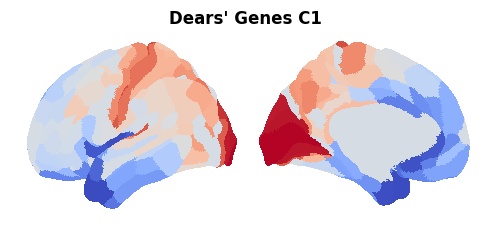

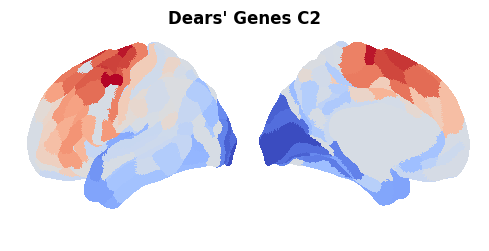

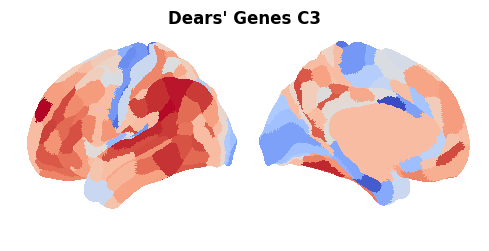

In [15]:
for name, cmap in zip(cnames, cmaps):
  plot_29k(cmap, center_min_max=0, title=name, colorbar=0) 

## Further cortical maps

In [16]:
## Helper function to get the HCP MMP regions
#!wget https://bitbucket.org/dpat/tools/raw/master/REF/ATLASES/HCP-MMP1_UniqueRegionList.csv -O data/misc/HCP-MMP1_UniqueRegionList.csv
def get_labels_hcp():
    """
    Get HCP atlas labels from source file and format for ggseg
    """
    hcp_info = (
        pd.read_csv('data/misc/HCP-MMP1_UniqueRegionList.csv')
        .rename(columns={'LR':'hemisphere', 'regionID':'id', 'region':'label'})
        .assign(structure='cortex')
        .assign(id=lambda x: [id-20 if id>180 else id for id in x['id']]) 
        # Aurina's HCP images code regions as 1-360, not 1-180,201-380
        # so recode to match the image files
    )
    labels_hcp = hcp_info.set_index('id')['label']
    return labels_hcp

#print(get_labels_hcp()[:180].to_list())

In [17]:
# load all the maps 
cm = pd.read_csv("data/misc/cortical_maps.csv")

# Get the list of corresponding regions for the loaded data
cmlabels = get_labels_hcp()[:180]

# Check if the parcel ordering corresponds
#cmlabels = ['V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', '4', '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'A1', 'PSL', 'SFL', 'PCV', 'STV', '7Pm', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '6ma', '7Am', '7Pl', '7PC', 'LIPv', 'VIP', 'MIP', '1', '2', '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', '44', '45', '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-46v', '46', 'a9-46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', '43', 'OP4', 'OP1', 'OP2-3', '52', 'RI', 'PFcm', 'PoI2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'PFt', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSda', 'STSdp', 'STSvp', 'TGd', 'TE1a', 'TE1p', 'TE2a', 'TF', 'TE2p', 'PHT', 'PH', 'TPOJ1', 'TPOJ2', 'TPOJ3', 'DVT', 'PGp', 'IP2', 'IP1', 'IP0', 'PFop', 'PF', 'PFm', 'PGi', 'PGs', 'V6A', 'VMV1', 'VMV3', 'PHA2', 'V4t', 'FST', 'V3CD', 'LO3', 'VMV2', '31pd', '31a', 'VVC', '25', 's32', 'pOFC', 'PoI1', 'Ig', 'FOP5', 'p10p', 'p47r', 'TGv', 'MBelt', 'LBelt', 'A4', 'STSva', 'TE1m', 'PI', 'a32pr', 'p24'];
print(np.all(np.array([s.lower() for s in cmlabels]) == np.array(mmp_labels)))

# List all other maps that are to be included:
cmaps_df = cm.drop(['d_intramod60','hill_dev','dCT'], axis=1).apply(lambda x: (x-np.mean(x))/np.std(x)).set_index(get_labels_hcp()[:180])
cmaps_df.columns

True


Index(['paquola_FC', 'T1T2', 'MEG_theta', 'glasser_GI', 'dMT', 'hill_evo',
       'externopyramidisation', 'thickness', 'PC1_neurosynth', 'G1_fMRI',
       'allom', 'CBF'],
      dtype='object')

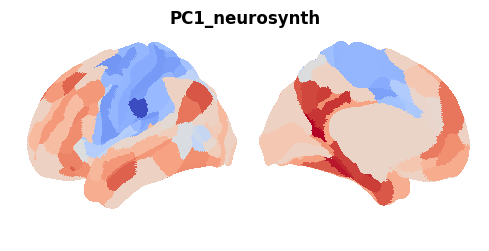

In [18]:
# Plot an example map
data29k = map_to_labels(cmaps_df["PC1_neurosynth"].to_numpy(), hcpmmpl, fill=0)
plot_29k(data29k, center_min_max=0, title="PC1_neurosynth", colorbar=0) 

In [19]:
for mapname in cmaps_df.columns:   
  data29k = map_to_labels(cmaps_df[mapname].to_numpy(), hcpmmpl, fill=0)
  cmaps.append(data29k)
  cnames.append(mapname)

In [20]:
print(cnames)
print(np.array(cmaps).shape)

["Dears' Genes C1", "Dears' Genes C2", "Dears' Genes C3", 'paquola_FC', 'T1T2', 'MEG_theta', 'glasser_GI', 'dMT', 'hill_evo', 'externopyramidisation', 'thickness', 'PC1_neurosynth', 'G1_fMRI', 'allom', 'CBF']
(15, 29696)


## Resting state gradients

In [21]:
# add gradients
from neuromaps.datasets import available_annotations, fetch_annotation
#for annotation in available_annotations(source=['margulies2016']):#(source=['abagen', 'margulies2016']):
#    print(annotation)
annotations = fetch_annotation(source=['margulies2016'])
print(sorted(annotations))

[('margulies2016', 'fcgradient01', 'fsLR', '32k'), ('margulies2016', 'fcgradient02', 'fsLR', '32k'), ('margulies2016', 'fcgradient03', 'fsLR', '32k'), ('margulies2016', 'fcgradient04', 'fsLR', '32k'), ('margulies2016', 'fcgradient05', 'fsLR', '32k'), ('margulies2016', 'fcgradient06', 'fsLR', '32k'), ('margulies2016', 'fcgradient07', 'fsLR', '32k'), ('margulies2016', 'fcgradient08', 'fsLR', '32k'), ('margulies2016', 'fcgradient09', 'fsLR', '32k'), ('margulies2016', 'fcgradient10', 'fsLR', '32k')]


In [22]:
import nibabel as nib
grayl=hcp.vertex_info['grayl'];
for a in annotations:
  data = nib.load(annotations[a][0]).darrays[0].data
  print(a[1], data[grayl].shape, end=", ")
  cmaps.append(data[grayl])
  cnames.append(a[1])  

fcgradient01 (29696,), fcgradient02 (29696,), fcgradient03 (29696,), fcgradient04 (29696,), fcgradient05 (29696,), fcgradient06 (29696,), fcgradient07 (29696,), fcgradient08 (29696,), fcgradient09 (29696,), fcgradient10 (29696,), 

In [23]:
print(cnames)
np.array(cmaps).shape

["Dears' Genes C1", "Dears' Genes C2", "Dears' Genes C3", 'paquola_FC', 'T1T2', 'MEG_theta', 'glasser_GI', 'dMT', 'hill_evo', 'externopyramidisation', 'thickness', 'PC1_neurosynth', 'G1_fMRI', 'allom', 'CBF', 'fcgradient01', 'fcgradient02', 'fcgradient03', 'fcgradient04', 'fcgradient05', 'fcgradient06', 'fcgradient07', 'fcgradient08', 'fcgradient09', 'fcgradient10']


(25, 29696)

## hansen receptor maps and xinhan cell types

In [26]:
# hansel receptor maps and xinhans cell type maps
yy = np.load("data/receptor_maps.L.fslr29k.npy", allow_pickle=1).item()
print(yy.keys())
receptor_maps = yy["maps"]
receptor_names = yy["receptor_names"]
print(receptor_maps.shape)

#xx=np.load("data/celltype_maps.VisDfc18.L.fslr29k.npy", allow_pickle=1).item()
xx=np.load("data/celltype_maps.Jorstad24cts.L.fslr29k.npy", allow_pickle=1).item()
print(xx.keys())
cell_type_maps = xx["maps"]
cell_type_names = xx["celltype_names"]
print(cell_type_maps.shape)

dict_keys(['maps', 'receptor_names'])
(16, 29696)
dict_keys(['maps', 'celltype_names'])
(24, 29696)


In [27]:
refmaps = np.concatenate((ymaps, cmaps, cell_type_maps, receptor_maps), axis=0)
refnames = ynames +  cnames + cell_type_names + receptor_names
refmaps.shape, len(refnames)

((101, 29696), 101)

In [28]:
print(refnames)

['yeo7_Visual', 'yeo7_Somatomotor', 'yeo7_Dorsal Attention', 'yeo7_Ventral Attention', 'yeo7_Limbic', 'yeo7_Frontoparietal', 'yeo7_Default', 'yeo17_network_1', 'yeo17_network_2', 'yeo17_network_3', 'yeo17_network_4', 'yeo17_network_5', 'yeo17_network_6', 'yeo17_network_7', 'yeo17_network_8', 'yeo17_network_9', 'yeo17_network_10', 'yeo17_network_11', 'yeo17_network_12', 'yeo17_network_13', 'yeo17_network_14', 'yeo17_network_15', 'yeo17_network_16', 'yeo17_network_17', 'ca_Visual1', 'ca_Visual2', 'ca_Somatomotor', 'ca_Cingulo-Opercular', 'ca_Dorsal-attention', 'ca_Language', 'ca_Frontoparietal', 'ca_Auditory', 'ca_Default', 'ca_Posterior-Multimodal', 'ca_Ventral-Multimodal', 'ca_Orbito-Affective', "Dears' Genes C1", "Dears' Genes C2", "Dears' Genes C3", 'paquola_FC', 'T1T2', 'MEG_theta', 'glasser_GI', 'dMT', 'hill_evo', 'externopyramidisation', 'thickness', 'PC1_neurosynth', 'G1_fMRI', 'allom', 'CBF', 'fcgradient01', 'fcgradient02', 'fcgradient03', 'fcgradient04', 'fcgradient05', 'fcgrad

## >> Save all of the collected maps

In [29]:
#np.save("data/all_cortical_reference_maps.fslr32k.l29.npy", dict(refmaps=refmaps, names = refnames))
np.save("data/all_cortical_reference_maps_v2.fslr32k.l29.npy", dict(refmaps=refmaps, names = refnames))

# Annotate the PCA components

In [30]:
import numpy as np
import pickle as pk
import pandas as pd

# First load the coefficients of the RS-PCA model
coeffs = np.load("results/scores/rs_pca.lin_weights.200.spatial_zscore.yfull.npy")
print("Linear coefficients:", coeffs.shape)

# if instead the contribution values calculated above should be used:
#pl = np.load(""results/scores/rs_pca.lin_weight_onebyone_contrib.values.diff.spatial_zscore.yresid.npy", allow_pickle=1).item();
#best = pl["best"]; unique_contrasts = pl["unique_contrasts"]; contrast_ids_to_show=pl["contrast_ids_to_show"]; contr = pl["contr"]; 

# Load the corresponding group pca components (to which all indiviudal pca components had been aligned)
pca = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 
print("Group PCA components:", pca.components_.shape)

# Load all the reference maps
#p = np.load("data/all_cortical_reference_maps.fslr32k.l29.npy", allow_pickle=1).item()
p = np.load("data/all_cortical_reference_maps_v2.fslr32k.l29.npy", allow_pickle=1).item()
refmaps= p["refmaps"]; refnames = p["names"];
print("Reference maps:", refmaps.shape, "\nE.g.", refnames[:5])

# Add information about the sources to the reference maps
#source = ["Yeo7"]*7 + ["Yeo17"]*17 + ["CA"]*12 + ["DearGenes"]*3 +  ["Neuromaps"]*12 + ["fcgrads"]*10 + ["CellTypes"]*18 + ["Receptors"]*16;
source = ["Yeo7"]*7 + ["Yeo17"]*17 + ["CA"]*12 + ["DearGenes"]*3 +  ["Neuromaps"]*12 + ["fcgrads"]*10 + ["CellTypes"]*24 + ["Receptors"]*16;
ref_overview_df = pd.DataFrame(dict(source=source, map_name=refnames))
ref_overview_df.tail(20)

Linear coefficients: (47, 200)
Group PCA components: (200, 29696)
Reference maps: (101, 29696) 
E.g. ['yeo7_Visual', 'yeo7_Somatomotor', 'yeo7_Dorsal Attention', 'yeo7_Ventral Attention', 'yeo7_Limbic']


,source,map_name
81,CellTypes,Chandelier
82,CellTypes,PVALB
83,CellTypes,SST
84,CellTypes,SST CHODL
85,Receptors,VAChT
86,Receptors,NAT
87,Receptors,5HT4
88,Receptors,D2
89,Receptors,5HT1a
90,Receptors,5HT1b


In [31]:
"""# Correlate group compoentns with reference maps
corrs = np_pearson_cor(pca.components_.T, refmaps.T)
corrs.shape""";

In [32]:
# Correlate components with refmaps
corrs = pearson_correlation(pca.components_, refmaps)



(200, 101) 0.9470106183387486 -0.6389842008539628


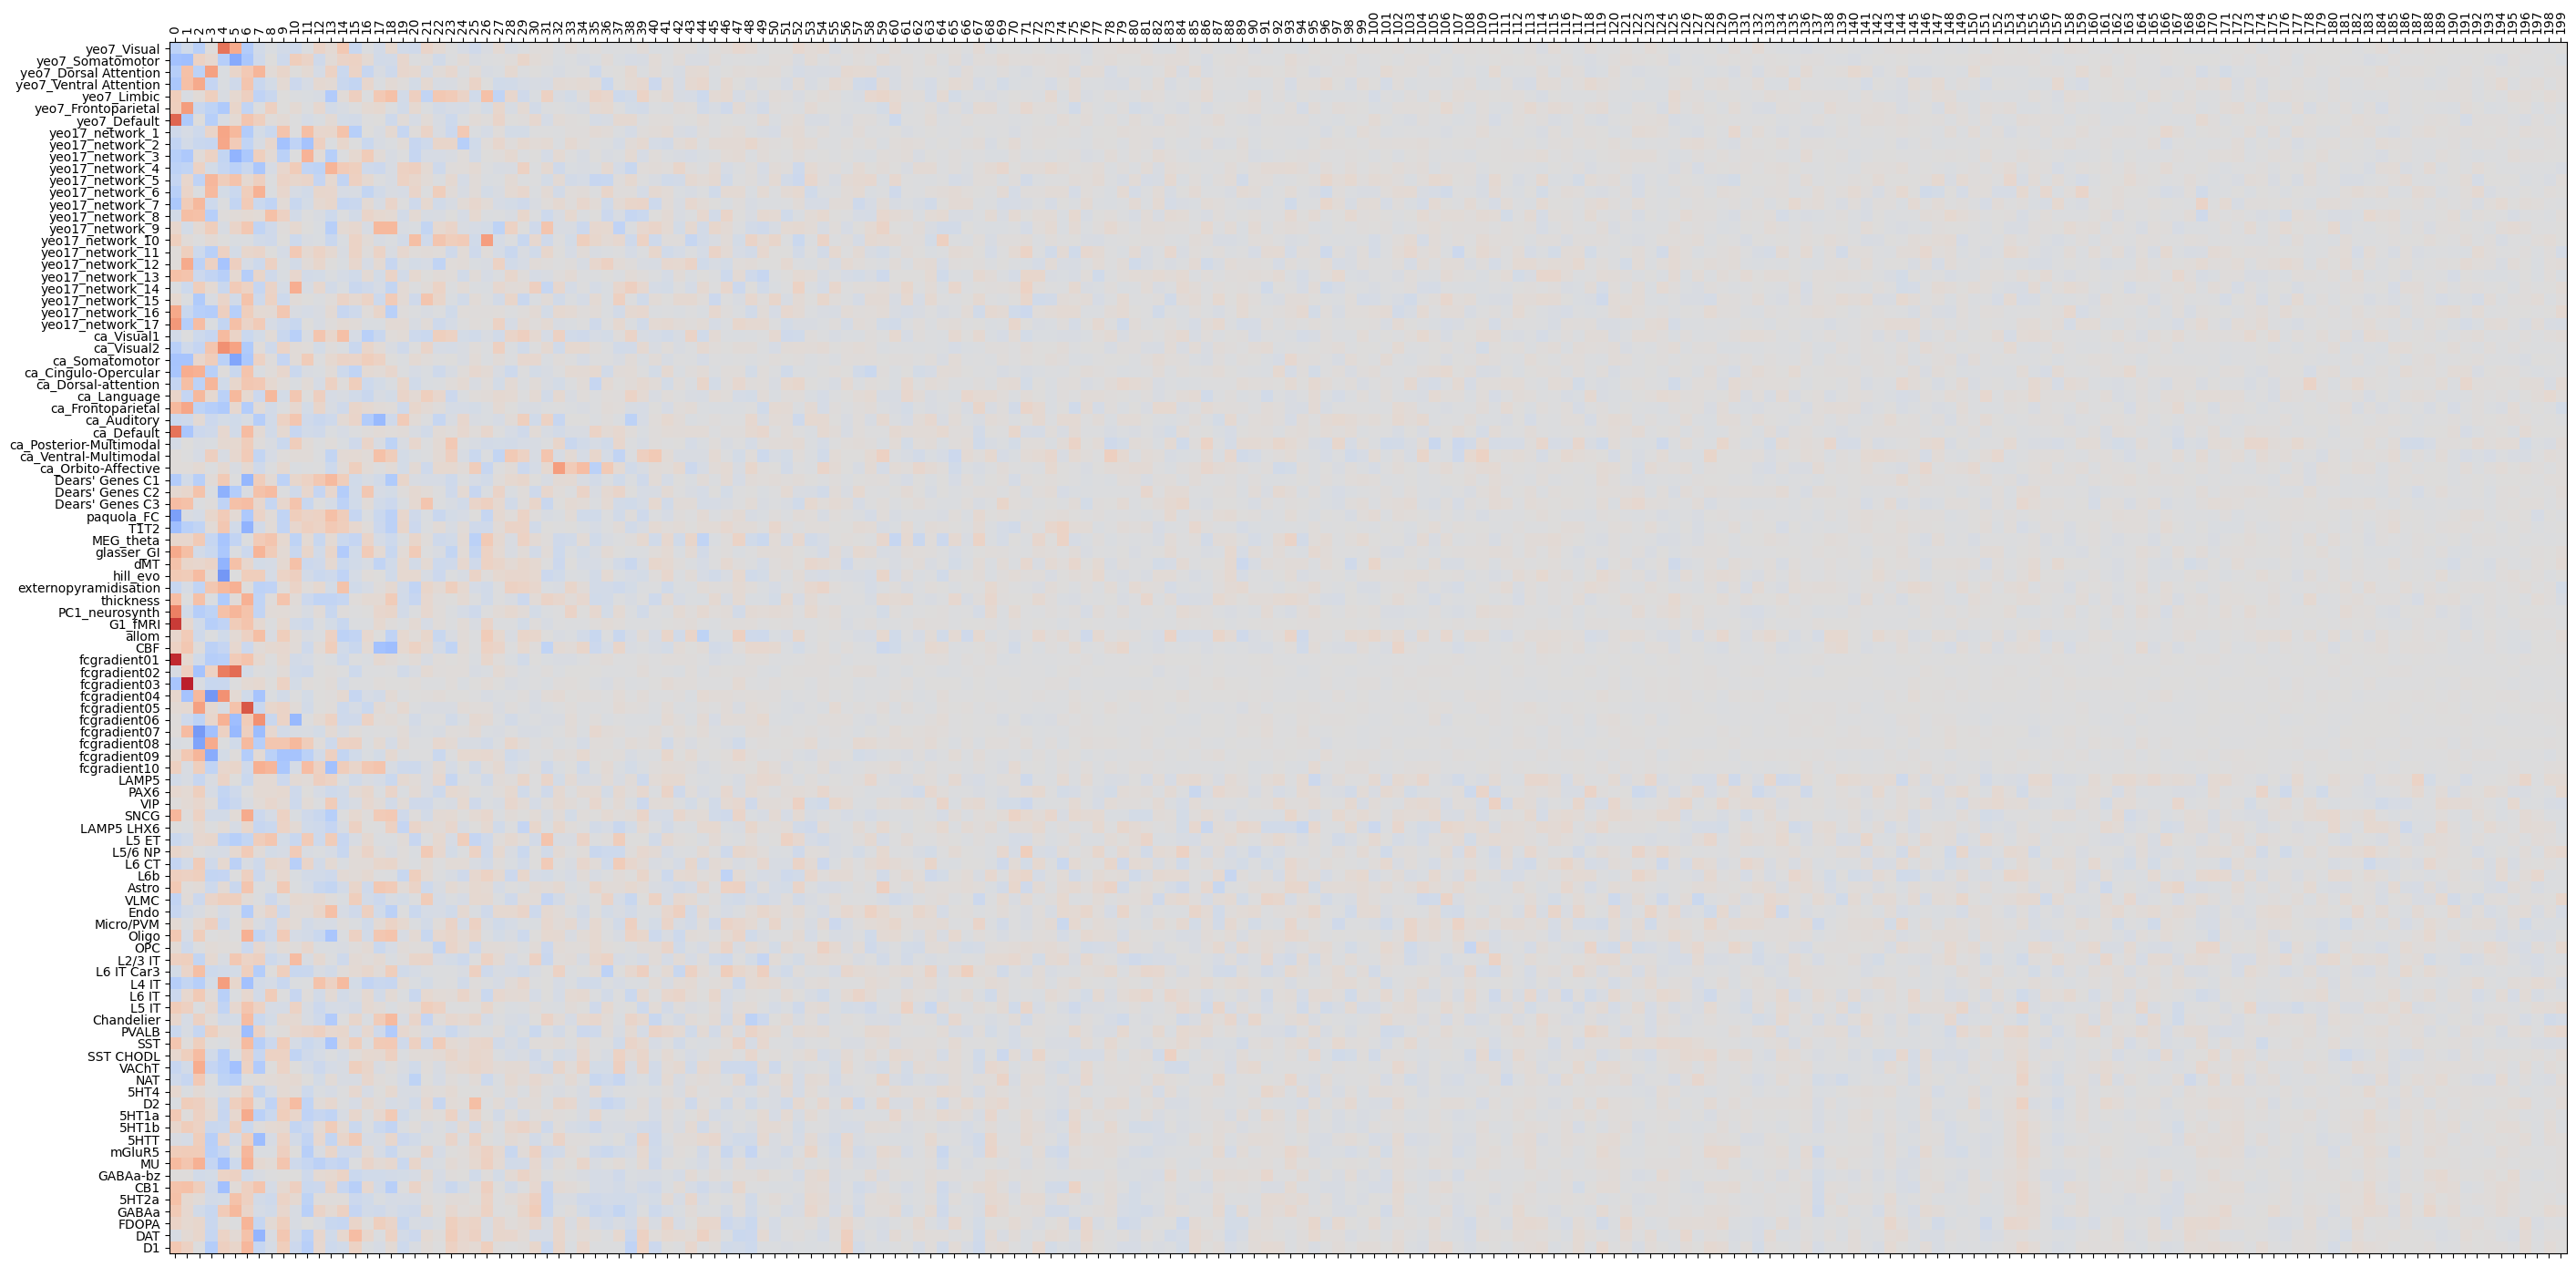

In [33]:
# Visuzalize the full correltations
print(corrs.shape, corrs.max(), corrs.min())
ax = plt.figure(figsize=(30,14)).gca()
ax.matshow(corrs.T, vmin=-1, vmax=1, cmap="coolwarm")
plt.yticks(np.arange(refmaps.shape[0]), refnames);
plt.xticks(np.arange(corrs.shape[0]), rotation=90);
plt.tight_layout()
plt.savefig("results/plots/rs_pca.component_correlation_with_refmaps_v2.png");

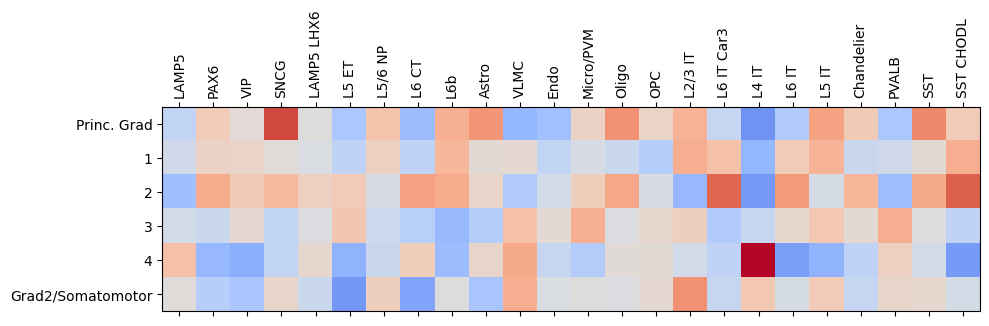

In [34]:
idxs = np.array(source)=="CellTypes"
ax = plt.figure(figsize=(10,14)).gca()
ax.matshow(corrs[:6, idxs], vmin=-0.4, vmax=0.4, cmap="coolwarm")
plt.xticks(np.arange(refmaps[idxs].shape[0]), np.array(refnames)[idxs],rotation=90);
plt.yticks(np.arange(6), ["Princ. Grad"] + ["1","2","3","4"] + ["Grad2/Somatomotor"]);
plt.tight_layout()

In [35]:
corrs[np.array([0,5]), :].shape

(2, 101)

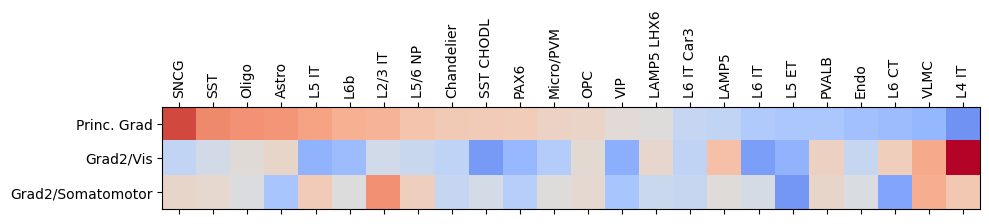

In [36]:
idxs = np.array(source)=="CellTypes"
ax = plt.figure(figsize=(10,14)).gca()
vals = corrs[np.array([0,4,5]), :][:, idxs]
sortedcts = np.argsort(vals[0])[::-1]
ax.matshow(vals[:, sortedcts], vmin=-0.4, vmax=0.4, cmap="coolwarm")
plt.xticks(np.arange(refmaps[idxs].shape[0]), np.array(refnames)[idxs][sortedcts],rotation=90);
plt.yticks(np.arange(3), ["Princ. Grad", "Grad2/Vis", "Grad2/Somatomotor"]);
plt.tight_layout()

OLD:
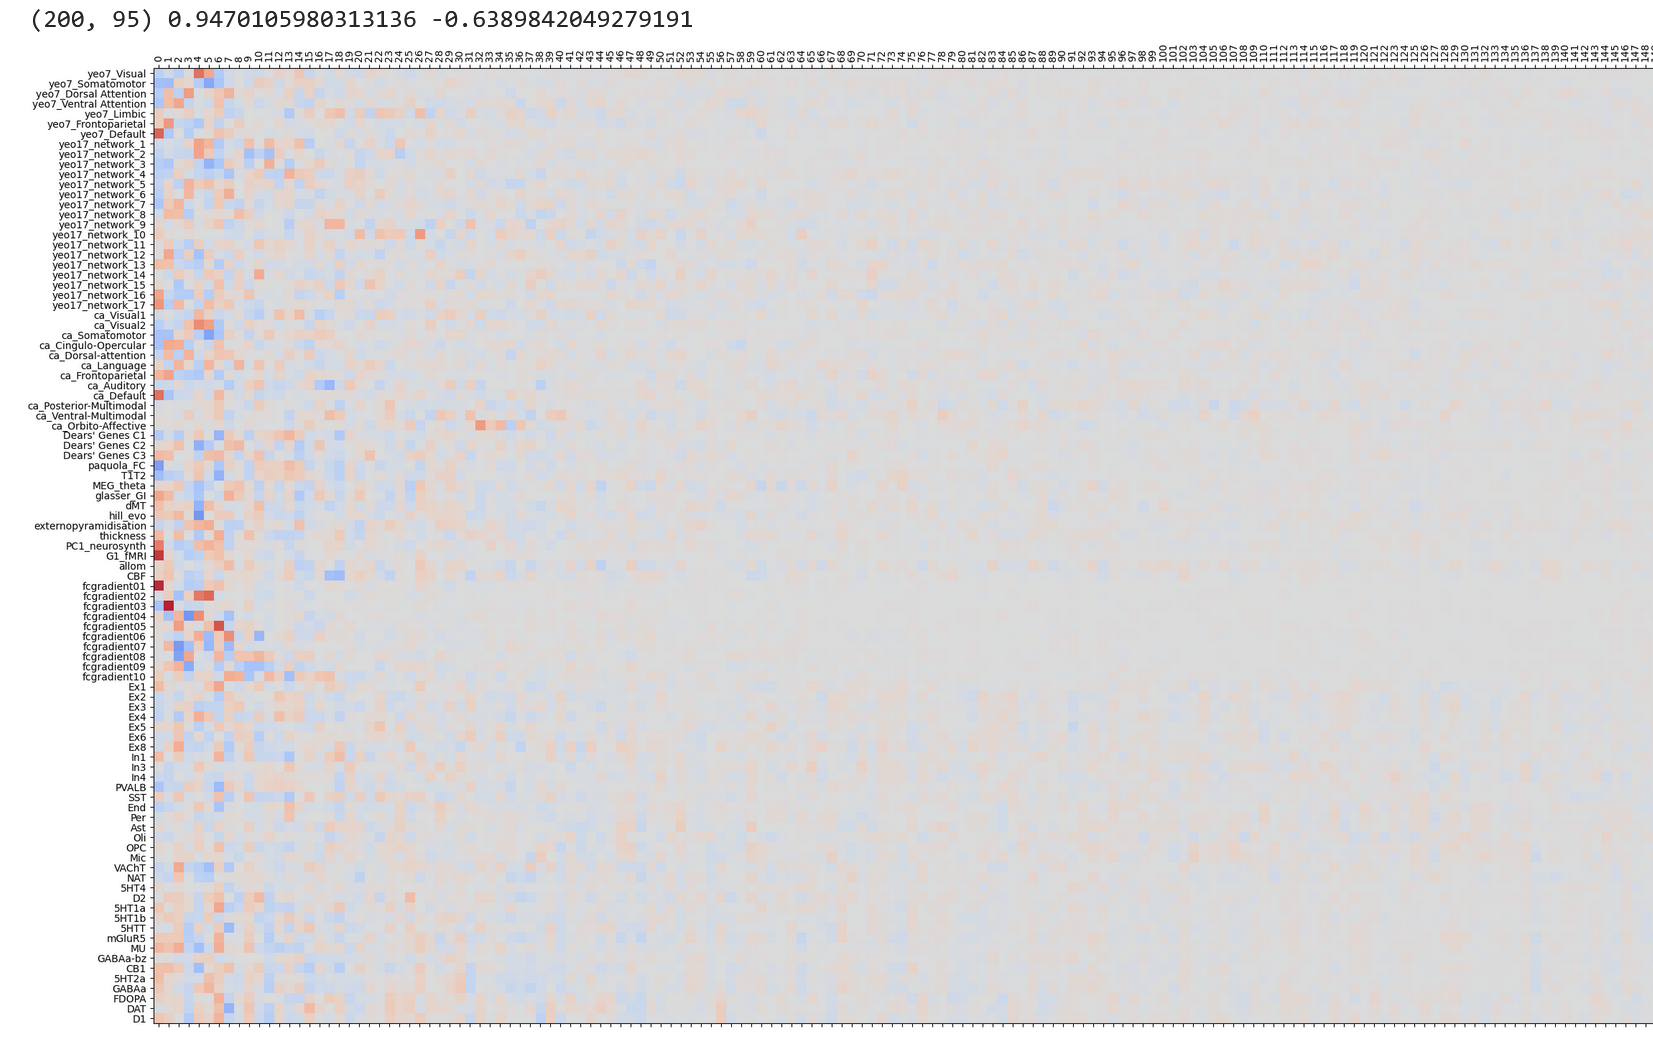


## General component annotation (saved as xls)

In [37]:
# annotate the components with the best 10 reference maps
import pandas as pd
best_refer = np.argsort(np.absolute(corrs), axis=1)[:, ::-1]
table = []
for cn in range(len(corrs)):
  table.append([refnames[rn] + f" ({corrs[cn, rn].round(3)})" for rn in best_refer[cn,:10]])

df = pd.DataFrame(table, columns = [f"Reference Map #{n+1}" for n in range(10)])
df.index.name = "Group Comp Coefficients"
comp_to_ref =df;
df.head(6)

,Reference Map #1,Reference Map #2,Reference Map #3,Reference Map #4,Reference Map #5,Reference Map #6,Reference Map #7,Reference Map #8,Reference Map #9,Reference Map #10
Group Comp Coefficients,,,,,,,,,,
0,fcgradient01 (0.929),G1_fMRI (0.881),yeo7_Default (0.725),ca_Default (0.67),PC1_neurosynth (0.614),paquola_FC (-0.59),yeo17_network_17 (0.507),yeo17_network_16 (0.421),glasser_GI (0.407),T1T2 (-0.383)
1,fcgradient03 (0.947),yeo7_Frontoparietal (0.484),ca_Frontoparietal (0.428),yeo17_network_12 (0.405),ca_Cingulo-Opercular (0.391),yeo7_Somatomotor (-0.386),fcgradient04 (-0.355),ca_Somatomotor (-0.345),ca_Default (-0.33),yeo17_network_3 (-0.305)
2,fcgradient07 (-0.623),fcgradient08 (-0.564),fcgradient05 (0.456),yeo7_Ventral Attention (0.412),VAChT (0.395),ca_Cingulo-Opercular (0.371),MU (0.369),fcgradient02 (-0.355),fcgradient09 (0.338),ca_Language (0.325)
3,fcgradient04 (-0.639),fcgradient09 (-0.52),yeo7_Dorsal Attention (0.455),fcgradient08 (0.401),fcgradient07 (-0.372),ca_Dorsal-attention (0.338),yeo17_network_5 (0.328),yeo17_network_6 (0.32),yeo17_network_16 (-0.273),D1 (-0.271)
4,yeo7_Visual (0.664),hill_evo (-0.634),fcgradient02 (0.625),ca_Visual2 (0.547),fcgradient04 (0.532),Dears' Genes C2 (-0.488),L4 IT (0.473),dMT (-0.463),yeo17_network_1 (0.436),yeo17_network_2 (0.424)
5,fcgradient02 (0.699),ca_Somatomotor (-0.557),yeo7_Somatomotor (-0.528),yeo17_network_3 (-0.464),ca_Visual2 (0.452),fcgradient07 (-0.43),yeo7_Visual (0.406),fcgradient06 (-0.396),externopyramidisation (0.374),VAChT (-0.372)


In [38]:
# annotate the reference maps with 10 best components 

import pandas as pd
best_comps = np.argsort(np.absolute(corrs), axis=0)[::-1]
table = []
for rn in range(corrs.shape[1]):
  row = [source[rn], refnames[rn]]
  row = row+[f"c{cn} ({corrs[cn, rn].round(3)})" for cn in best_comps[:10,rn]]
  table.append(row)

df = pd.DataFrame(table, columns = ["source", "refmap"]+[f"best_rs_comp_{n+1}" for n in range(10)])
ref_to_comp =df;


df.head(3)

,source,refmap,best_rs_comp_1,best_rs_comp_2,best_rs_comp_3,best_rs_comp_4,best_rs_comp_5,best_rs_comp_6,best_rs_comp_7,best_rs_comp_8,best_rs_comp_9,best_rs_comp_10
0,Yeo7,yeo7_Visual,c4 (0.664),c5 (0.406),c6 (-0.281),c2 (-0.241),c14 (0.214),c0 (-0.212),c15 (-0.141),c12 (0.111),c10 (-0.105),c21 (0.103)
1,Yeo7,yeo7_Somatomotor,c5 (-0.528),c1 (-0.386),c0 (-0.374),c6 (-0.326),c4 (-0.265),c10 (0.168),c2 (0.129),c15 (0.125),c11 (0.115),c14 (0.11)
2,Yeo7,yeo7_Dorsal Attention,c3 (0.455),c7 (0.336),c1 (0.271),c0 (-0.26),c2 (-0.211),c6 (0.207),c16 (-0.156),c13 (0.132),c14 (-0.128),c15 (0.12)


In [39]:
# best exclusive fiting 
sources = ref_overview_df["source"]
assignments = []
assignmat = np.zeros_like(corrs)

for nc, category in enumerate(sources.unique()):
  excl = np.where(sources!=category)[0]
  incl = np.where(sources==category)[0]
  cm = corrs.copy()
  cm[:,excl]=0;
  i=0;
  print(" " + category, end=": ");
  while i!=len(incl):
    print(i,end=",")
    c,m = np.unravel_index(np.absolute(cm).argmax(), cm.shape)
    #_, pv_spin = spintest(pca.components_[c], refmaps[m], v=False, spin_perm=sp)
    assignments.append([category, m, np.array(refnames)[m], c, cm[c,m]])#,pv_spin])
    cm[c,:]=0; cm[:,m]=0;
    assignmat[c,m]=nc+1;
    i=i+1;
    
df = pd.DataFrame(assignments, columns = ["source", "map#", "map_name", "comp#", "r"])#, "p"])
#plt.matshow(assignmat.T, cmap="tab20")
comp_to_ref_source_excl =df;

df

 Yeo7: 0,1,2,3,4,5,6, Yeo17: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, CA: 0,1,2,3,4,5,6,7,8,9,10,11, DearGenes: 0,1,2, Neuromaps: 0,1,2,3,4,5,6,7,8,9,10,11, fcgrads: 0,1,2,3,4,5,6,7,8,9, CellTypes: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23, Receptors: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,

,source,map#,map_name,comp#,r
0,Yeo7,6,yeo7_Default,0,0.725183
1,Yeo7,0,yeo7_Visual,4,0.664092
2,Yeo7,1,yeo7_Somatomotor,5,-0.527809
3,Yeo7,5,yeo7_Frontoparietal,1,0.484173
4,Yeo7,2,yeo7_Dorsal Attention,3,0.455035
...,...,...,...,...,...
96,Receptors,90,5HT1b,18,-0.187128
97,Receptors,98,FDOPA,9,0.160176
98,Receptors,96,5HT2a,31,-0.157346
99,Receptors,94,GABAa-bz,14,0.122803


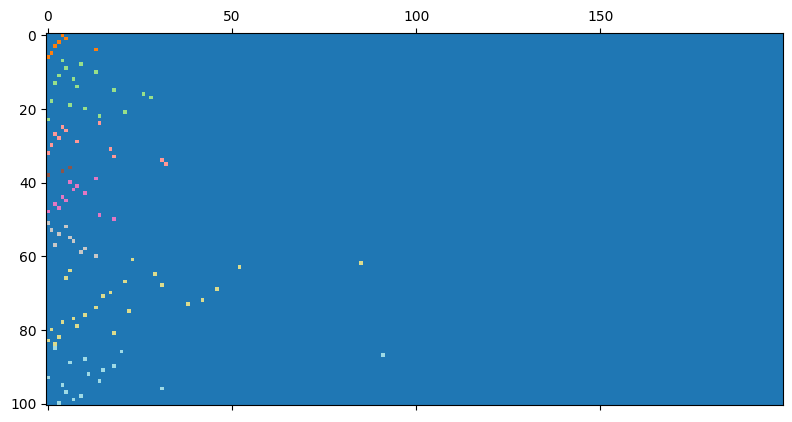

In [40]:
plt.matshow(assignmat.T, cmap="tab20")

In [41]:
# highest fitting reference map per category for each components

# annotate the components with the best 10 reference maps
import pandas as pd
best_refer = np.argsort(np.absolute(corrs), axis=1)[:, ::-1]
table = []
for cn in range(len(corrs)):
  row = []#[cn]
  for nc, category in enumerate(sources.unique()):
    incl = np.where(sources==category)[0]
    rn = np.argsort(np.absolute(corrs[cn,incl]))[::-1][0]
    row.append(np.array(refnames)[incl][rn] + f" ({corrs[cn,incl][rn].round(3)})")
  table.append(row)
               
df = pd.DataFrame(table, columns = sources.unique())
df.index.name = "RS-Component"
comp_to_ref_best_by_cat =df;
df.head(6)

,Yeo7,Yeo17,CA,DearGenes,Neuromaps,fcgrads,CellTypes,Receptors
RS-Component,,,,,,,,
0,yeo7_Default (0.725),yeo17_network_17 (0.507),ca_Default (0.67),Dears' Genes C3 (0.295),G1_fMRI (0.881),fcgradient01 (0.929),SNCG (0.332),MU (0.31)
1,yeo7_Frontoparietal (0.484),yeo17_network_12 (0.405),ca_Frontoparietal (0.428),Dears' Genes C3 (0.268),glasser_GI (0.287),fcgradient03 (0.947),L4 IT (-0.179),CB1 (0.269)
2,yeo7_Ventral Attention (0.412),yeo17_network_7 (0.322),ca_Cingulo-Opercular (0.371),Dears' Genes C2 (0.255),hill_evo (0.299),fcgradient07 (-0.623),SST CHODL (0.297),VAChT (0.395)
3,yeo7_Dorsal Attention (0.455),yeo17_network_5 (0.328),ca_Dorsal-attention (0.338),Dears' Genes C1 (0.028),G1_fMRI (-0.254),fcgradient04 (-0.639),L6b (-0.173),D1 (-0.271)
4,yeo7_Visual (0.664),yeo17_network_1 (0.436),ca_Visual2 (0.547),Dears' Genes C2 (-0.488),hill_evo (-0.634),fcgradient02 (0.625),L4 IT (0.473),CB1 (-0.379)
5,yeo7_Somatomotor (-0.528),yeo17_network_3 (-0.464),ca_Somatomotor (-0.557),Dears' Genes C2 (-0.268),externopyramidisation (0.374),fcgradient02 (0.699),L5 ET (-0.253),VAChT (-0.372)


In [42]:
# Annotate best components by task

tnames_mid = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]

table = []
table_small = []

for tn in range(coeffs.shape[0]):
  best_coeff_ids = np.argsort(np.absolute(coeffs[tn,:]))[::-1];
  for cn in best_coeff_ids[:5]:
    row = [tn, unique_contrasts[tn], cn, coeffs[tn,cn]] + [refnames[rn] + f" ({corrs[cn, rn].round(3)})" for rn in best_refer[cn,:10]]
    table.append(row)
    if tn in cids: table_small.append(row)

header = ["cn", "contrast", "comp#", "coeff"] + [f"BestRef#{rn+1}" for rn in range(10)]
all_tasks_to_ref =pd.DataFrame(table, columns=header);
selected_tasks_to_ref =pd.DataFrame(table_small, columns=header);
selected_tasks_to_ref.head(4)

,cn,contrast,comp#,coeff,BestRef#1,BestRef#2,BestRef#3,BestRef#4,BestRef#5,BestRef#6,BestRef#7,BestRef#8,BestRef#9,BestRef#10
0,2,EMOTION_FACES-SHAPES,7,-0.223023,fcgradient06 (0.533),DAT (-0.454),fcgradient07 (-0.403),5HTT (-0.399),fcgradient10 (0.381),yeo17_network_6 (0.367),glasser_GI (0.345),fcgradient04 (-0.344),yeo7_Dorsal Attention (0.336),yeo17_network_4 (-0.324)
1,2,EMOTION_FACES-SHAPES,5,0.187855,fcgradient02 (0.699),ca_Somatomotor (-0.557),yeo7_Somatomotor (-0.528),yeo17_network_3 (-0.464),ca_Visual2 (0.452),fcgradient07 (-0.43),yeo7_Visual (0.406),fcgradient06 (-0.396),externopyramidisation (0.374),VAChT (-0.372)
2,2,EMOTION_FACES-SHAPES,11,0.125169,yeo17_network_2 (-0.356),yeo17_network_3 (0.353),fcgradient10 (0.293),yeo17_network_1 (0.283),D1 (-0.246),mGluR5 (-0.244),GABAa (-0.241),fcgradient09 (-0.232),DAT (-0.212),5HT2a (-0.207)
3,2,EMOTION_FACES-SHAPES,23,0.114760,ca_Posterior-Multimodal (0.206),yeo7_Limbic (0.192),CBF (-0.188),DAT (0.179),glasser_GI (-0.173),yeo17_network_10 (0.164),externopyramidisation (0.164),LAMP5 (-0.162),FDOPA (0.156),ca_Ventral-Multimodal (0.155)


In [43]:
# Annotate highest fitting reference map of each type per 4 best components by task

table = []
sources=np.array(source)

for tn in cids:
  best_coeff_ids = np.argsort(np.absolute(coeffs[tn,:]))[::-1];
  for cn in best_coeff_ids[:4]:
    row = [tn, unique_contrasts[tn], cn, coeffs[tn,cn]]
    for nc, category in enumerate(np.unique(sources)):
        incl = np.where(sources==category)[0]
        rn = np.argsort(np.absolute(corrs[cn,incl]))[::-1][0]
        row.append(np.array(refnames)[incl][rn] + f" ({corrs[cn,incl][rn].round(3)})")
        
    table.append(row)

header = ["cn", "contrast", "comp#", "coeff"] + list(np.array(np.unique(sources)))
supplem_table3 =pd.DataFrame(table, columns=header);
supplem_table3.head(5)

,cn,contrast,comp#,coeff,CA,CellTypes,DearGenes,Neuromaps,Receptors,Yeo17,Yeo7,fcgrads
0,8,LANGUAGE_STORY-MATH,1,-0.522951,ca_Frontoparietal (0.428),L4 IT (-0.179),Dears' Genes C3 (0.268),glasser_GI (0.287),CB1 (0.269),yeo17_network_12 (0.405),yeo7_Frontoparietal (0.484),fcgradient03 (0.947)
1,8,LANGUAGE_STORY-MATH,6,0.213514,ca_Somatomotor (-0.315),SNCG (0.402),Dears' Genes C1 (-0.45),T1T2 (-0.471),5HT1a (0.402),yeo17_network_3 (-0.315),yeo7_Somatomotor (-0.326),fcgradient05 (0.78)
2,8,LANGUAGE_STORY-MATH,0,0.205610,ca_Default (0.67),SNCG (0.332),Dears' Genes C3 (0.295),G1_fMRI (0.881),MU (0.31),yeo17_network_17 (0.507),yeo7_Default (0.725),fcgradient01 (0.929)
3,8,LANGUAGE_STORY-MATH,8,-0.201458,ca_Language (0.321),L5 ET (0.234),Dears' Genes C2 (0.3),MEG_theta (0.239),D2 (-0.203),yeo17_network_8 (0.272),yeo7_Frontoparietal (0.143),fcgradient10 (0.34)
4,38,WM_2BK-0BK,1,0.260534,ca_Frontoparietal (0.428),L4 IT (-0.179),Dears' Genes C3 (0.268),glasser_GI (0.287),CB1 (0.269),yeo17_network_12 (0.405),yeo7_Frontoparietal (0.484),fcgradient03 (0.947)


In [49]:
# Save all to an multisheet xlsx
#writer = pd.ExcelWriter("SupplementaryFileA_-_RS_component_annotation.xlsx", engine="xlsxwriter")
writer = pd.ExcelWriter("SupplementaryFileA_-_RS_component_annotation_v2.xlsx", engine="xlsxwriter")

pd.DataFrame(corrs, columns = refnames).to_excel(writer, sheet_name="all_corrs")
comp_to_ref.to_excel(writer, sheet_name="comp_to_ref")
ref_to_comp.to_excel(writer, sheet_name="ref_to_comp")
comp_to_ref_source_excl.to_excel(writer, sheet_name="ref_to_comp (excl in source)") # (exclusive within category)
comp_to_ref_best_by_cat.to_excel(writer, sheet_name="comp_to_ref (best by source)")
all_tasks_to_ref.to_excel(writer, sheet_name="task_contr_to_ref")
selected_tasks_to_ref.to_excel(writer, sheet_name="sel_task_contr_to_ref")
supplem_table3.to_excel(writer, sheet_name="supplem_table3")

writer.close()

# Task specific associations (along with spintests)

https://brainspace.readthedocs.io/en/latest/python_doc/auto_examples/plot_tutorial3.html#variogram-matching

In [13]:
import numpy as np
import pickle as pk
import pandas as pd
#from scipy.stats import false_discovery_control

# First load the coefficients of the RS-PCA model
coeffs = np.load("results/scores/rs_pca.lin_weights.200.spatial_zscore.yfull.npy")
print("Linear coefficients:", coeffs.shape)

# if instead the contribution values calculated above should be used:
#pl = np.load(""results/scores/rs_pca.lin_weight_onebyone_contrib.values.diff.spatial_zscore.yresid.npy", allow_pickle=1).item();
#best = pl["best"]; unique_contrasts = pl["unique_contrasts"]; contrast_ids_to_show=pl["contrast_ids_to_show"]; contr = pl["contr"]; 

# Load the corresponding group pca components (to which all indiviudal pca components had been aligned)
pca = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 
print("Group PCA components:", pca.components_.shape)

# Load all the reference maps
#p = np.load("data/all_cortical_reference_maps.fslr32k.l29.npy", allow_pickle=1).item()
p = np.load("data/all_cortical_reference_maps_v2.fslr32k.l29.npy", allow_pickle=1).item()
refmaps= p["refmaps"]; refnames = p["names"];
print("Reference maps:", refmaps.shape, "\nE.g.", refnames[:5])

# Add information about the sources to the reference maps
#source = ["Yeo7"]*7 + ["Yeo17"]*17 + ["CA"]*12 + ["DearGenes"]*3 +  ["Neuromaps"]*12 + ["fcgrads"]*10 + ["CellTypes"]*18 + ["Receptors"]*16;
source = ["Yeo7"]*7 + ["Yeo17"]*17 + ["CA"]*12 + ["DearGenes"]*3 +  ["Neuromaps"]*12 + ["fcgrads"]*10 + ["CellTypes"]*24 + ["Receptors"]*16;

corrs = pearson_correlation(pca.components_, refmaps)
print("Correlations:", corrs.shape)

ref_overview_df = pd.DataFrame(dict(source=source, map_name=refnames))
ref_overview_df.tail(2)

Linear coefficients: (47, 200)
Group PCA components: (200, 29696)
Reference maps: (101, 29696) 
E.g. ['yeo7_Visual', 'yeo7_Somatomotor', 'yeo7_Dorsal Attention', 'yeo7_Ventral Attention', 'yeo7_Limbic']
Correlations: (200, 101)


,source,map_name
99,Receptors,DAT
100,Receptors,D1


### Spintest function

In [ ]:
import numpy as np
from scipy.stats import spearmanr
from brainspace.null_models import SpinPermutations
import hcp_utils as hcp
from brainspace.datasets import load_gradient, load_marker, load_conte69

"""
#def single_pearson(a,b):
#    return pearson_correlation([a], [b]).squeeze()

def single_pearson(map1, map2):
    c = np.vstack([map1,map2])
    d = c[:,~np.any(np.isnan(c), axis=0)]
    r,p= scipy.stats.mstats.pearsonr(d[0],d[1])
    return r,p
""";

def spintest2(feature, target, n_rand=1000, sp=None, grayl=hcp.vertex_info['grayl'], corr_fn = scipy.stats.mstats.pearsonr):
    # alternative corr_fn = spearmanr
    
    tmp = np.zeros(32492)
    tmp[:] = np.nan
    tmp[grayl] = feature#[grayl]
    feature = tmp
    
    tmp = np.zeros(32492)
    tmp[:] = np.nan
    tmp[grayl] = target#[grayl]
    target = tmp
    
    mask = ~np.isnan(feature) & ~np.isnan(target)
    r_obs, pv_obs = corr_fn(feature[mask], target[mask])
    
    if sp is None:
        sp = SpinPermutations(n_rep=n_rand, random_state=19883)
        sp.fit(sphere_lh)
        
    feat_rotated = sp.randomize(feature)
    r_spin = np.zeros(len(feat_rotated))
    #print(feat_rotated.shape);
    for i, perm in enumerate(feat_rotated):
        #mask_rot = mask & ~np.isnan(perm)  # Remove midline
        mask_rot = ~np.isnan(perm)  &  ~np.isnan(target)# Remove midline
        r_spin[i] = corr_fn(perm[mask_rot], target[mask_rot])[0]
    
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))
    
    return r_obs, pv_spin


In [12]:
sphere_lh, sphere_rh = load_conte69(as_sphere=True)
n_rand = 10000 #n_rand = 5000
sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh)

SpinPermutations(n_rep=10000, random_state=0)

In [15]:
thickness_lh, thickness_rh = load_marker('thickness')
thickness = np.concatenate([thickness_lh])
embedding,_ = load_gradient('fc', idx=0)
#thickness_rotated = sp.randomize(thickness_lh)
print(thickness_lh.shape, embedding.shape), #thickness_rotated.shape
spintest2(thickness, embedding, sp=sp, grayl=slice(None))

(32492,) (32492,)


(0.3036771475396628, 0.113)

## Batch spintest with bonferroni

In [ ]:
ref_categories=np.array(source)
unique_ref_categories=np.unique(ref_categories)

pairs_by_category = {cat : [] for cat in unique_ref_categories}

pvals_by_category_pairs = {cat : [] for cat in unique_ref_categories}
rvals_by_category_pairs = {cat : [] for cat in unique_ref_categories}
indicices_by_category = {cat : [] for cat in unique_ref_categories}

for contrast_id in tqdm(cids):
  best_predicitve_rs_component_ids = np.argsort(np.absolute(coeffs[contrast_id,:]))[::-1];
  for comp_nr in tqdm(best_predicitve_rs_component_ids[:4]):
      for category in unique_ref_categories:
        
        incl = np.where(ref_categories==category)[0]
        rn = np.argsort(np.absolute(corrs[comp_nr,incl]))[::-1][0]
        
        refname = np.array(refnames)[incl][rn]
        r, p = spintest2(pca.components_[comp_nr], refmaps[incl][rn], sp=sp)
        rb= corrs[comp_nr,incl][rn]#.round(3)
        #print(r,rb)
        assert np.isclose(r,rb)
        
        pair = [comp_nr, refname]
        if not pair in pairs_by_category[category]:
            pairs_by_category[category].append(pair)
            pvals_by_category_pairs[category].append(float(p));
            rvals_by_category_pairs[category].append(float(r));
            
        #indicices_by_category[category].append(pairs_by_category[category].index(pair))


In [ ]:
b = pvals_by_category_pairs.copy()

In [ ]:
import numpy as np
payload = dict(pairs_by_category=pairs_by_category, pvals_by_category_pairs=pvals_by_category_pairs, rvals_by_category_pairs=rvals_by_category_pairs, indicices_by_category=indicices_by_category, unique_ref_categories=unique_ref_categories, ref_categories=ref_categories)
#np.save("annotation_pre_outcomes.10000.npy", payload)

In [3]:
payload = np.load("annotation_pre_outcomes.10000.npy", allow_pickle=1).item()
payload.keys()

pairs_by_category=payload["pairs_by_category"]
pvals_by_category_pairs=payload["pvals_by_category_pairs"]
rvals_by_category_pairs=payload["rvals_by_category_pairs"]
indicices_by_category=payload["indicices_by_category"]
unique_ref_categories=payload["unique_ref_categories"]
ref_categories=payload["ref_categories"]

In [ ]:
#from scipy.stats import false_discovery_control

def false_discovery_control(ps, *, axis=0, method='bh'):
    # Input Validation and Special Cases
    ps = np.asarray(ps)
    
    ps_in_range = (np.issubdtype(ps.dtype, np.number)
                   and np.all(ps == np.clip(ps, 0, 1)))
    if not ps_in_range:
        raise ValueError("`ps` must include only numbers between 0 and 1.")
    
    methods = {'bh', 'by'}
    if method.lower() not in methods:
        raise ValueError(f"Unrecognized `method` '{method}'."
                         f"Method must be one of {methods}.")
    method = method.lower()
    
    if axis is None:
        axis = 0
        ps = ps.ravel()
    
    axis = np.asarray(axis)[()]
    if not np.issubdtype(axis.dtype, np.integer) or axis.size != 1:
        raise ValueError("`axis` must be an integer or `None`")
    
    if ps.size <= 1 or ps.shape[axis] <= 1:
        return ps[()]
    
    ps = np.moveaxis(ps, axis, -1)
    m = ps.shape[-1]
    
    order = np.argsort(ps, axis=-1)
    ps = np.take_along_axis(ps, order, axis=-1)  # this copies ps
    
    # Equation 1 of [1] rearranged to reject when p is less than specified q
    i = np.arange(1, m+1)
    ps *= m / i
    
    # Theorem 1.3 of [2]
    if method == 'by':
        ps *= np.sum(1 / i)
    
    # accounts for rejecting all null hypotheses i for i < k, where k is
    # defined in Eq. 1 of either [1] or [2]. See [3]. Starting with the index j
    # of the second to last element, we replace element j with element j+1 if
    # the latter is smaller.
    np.minimum.accumulate(ps[..., ::-1], out=ps[..., ::-1], axis=-1)
    
    # Restore original order of axes and data
    np.put_along_axis(ps, order, values=ps.copy(), axis=-1)
    ps = np.moveaxis(ps, -1, axis)
    
    return np.clip(ps, 0, 1)

In [10]:
# correct pvals for multiple comparison per reference category
for category in unique_ref_categories:
    pvals_by_category_pairs[category] = false_discovery_control(pvals_by_category_pairs[category])

In [15]:
# build the table:
table = []
for contrast_id in tqdm(cids):
  best_predicitve_rs_component_ids = np.argsort(np.absolute(coeffs[contrast_id,:]))[::-1];
  for comp_nr in tqdm(best_predicitve_rs_component_ids[:4]):
        #print(comp_nr)
        row = [contrast_id, unique_contrasts[contrast_id], comp_nr, coeffs[contrast_id,comp_nr]]
        for category in unique_ref_categories:
            incl = np.where(ref_categories==category)[0]
            rn = np.argsort(np.absolute(corrs[comp_nr,incl]))[::-1][0]
            refname = np.array(refnames)[incl][rn]
            pair = [comp_nr, refname]
            idx = pairs_by_category[category].index(pair)
            p = pvals_by_category_pairs[category][idx]
            r = rvals_by_category_pairs[category][idx]
            #print(r, corrs[comp_nr,incl][rn])
            row.append(refname + f" (r={np.round(r,3)}, p={np.round(p,5)})")
        
        print(row)
        table.append(row)
            

header = ["cn", "contrast", "comp#", "coeff"] + list(unique_ref_categories)
xx =pd.DataFrame(table, columns=header);
#xx.head(5)

100%|██████████| 4/4 [00:00<00:00, 1719.68it/s]


[8, 'LANGUAGE_STORY-MATH', 1, -0.5229514, 'ca_Frontoparietal (r=0.428, p=0.0)', 'L4 IT (r=-0.179, p=0.12)', "Dears' Genes C3 (r=0.268, p=0.0825)", 'glasser_GI (r=0.287, p=0.01162)', 'CB1 (r=0.269, p=0.0297)', 'yeo17_network_12 (r=0.405, p=0.0)', 'yeo7_Frontoparietal (r=0.484, p=0.0)', 'fcgradient03 (r=0.947, p=0.0)']
[8, 'LANGUAGE_STORY-MATH', 6, 0.21351421, 'ca_Somatomotor (r=-0.315, p=0.00056)', 'SNCG (r=0.402, p=0.0)', "Dears' Genes C1 (r=-0.45, p=0.0)", 'T1T2 (r=-0.471, p=0.0)', '5HT1a (r=0.402, p=0.0015)', 'yeo17_network_3 (r=-0.315, p=0.00225)', 'yeo7_Somatomotor (r=-0.326, p=0.00562)', 'fcgradient05 (r=0.78, p=0.0)']
[8, 'LANGUAGE_STORY-MATH', 0, 0.20561004, 'ca_Default (r=0.67, p=0.0)', 'SNCG (r=0.332, p=0.03)', "Dears' Genes C3 (r=0.295, p=0.108)", 'G1_fMRI (r=0.881, p=0.0)', 'MU (r=0.31, p=0.09062)', 'yeo17_network_17 (r=0.507, p=0.00025)', 'yeo7_Default (r=0.725, p=0.0)', 'fcgradient01 (r=0.929, p=0.0)']
[8, 'LANGUAGE_STORY-MATH', 8, -0.20145768, 'ca_Language (r=0.321, p=0.0


100%|██████████| 4/4 [00:00<00:00, 1612.11it/s]


[38, 'WM_2BK-0BK', 1, 0.2605337, 'ca_Frontoparietal (r=0.428, p=0.0)', 'L4 IT (r=-0.179, p=0.12)', "Dears' Genes C3 (r=0.268, p=0.0825)", 'glasser_GI (r=0.287, p=0.01162)', 'CB1 (r=0.269, p=0.0297)', 'yeo17_network_12 (r=0.405, p=0.0)', 'yeo7_Frontoparietal (r=0.484, p=0.0)', 'fcgradient03 (r=0.947, p=0.0)']
[38, 'WM_2BK-0BK', 8, 0.187167, 'ca_Language (r=0.321, p=0.0)', 'L5 ET (r=0.234, p=0.10036)', "Dears' Genes C2 (r=0.3, p=0.13779)", 'MEG_theta (r=0.239, p=0.12288)', 'D2 (r=-0.203, p=0.10465)', 'yeo17_network_8 (r=0.272, p=0.00086)', 'yeo7_Frontoparietal (r=0.143, p=0.06825)', 'fcgradient10 (r=0.34, p=0.0)']
[38, 'WM_2BK-0BK', 7, 0.12146126, 'ca_Auditory (r=-0.263, p=0.01625)', 'L6 IT Car3 (r=-0.273, p=0.06617)', "Dears' Genes C2 (r=0.26, p=0.42846)", 'glasser_GI (r=0.345, p=0.1089)', 'DAT (r=-0.454, p=0.012)', 'yeo17_network_6 (r=0.367, p=0.0)', 'yeo7_Dorsal Attention (r=0.336, p=0.00175)', 'fcgradient06 (r=0.533, p=0.0)']
[38, 'WM_2BK-0BK', 6, -0.112192646, 'ca_Somatomotor (r=-0.


100%|██████████| 4/4 [00:00<00:00, 1718.80it/s]


[16, 'MOTOR_CUE-AVG', 0, -0.28750518, 'ca_Default (r=0.67, p=0.0)', 'SNCG (r=0.332, p=0.03)', "Dears' Genes C3 (r=0.295, p=0.108)", 'G1_fMRI (r=0.881, p=0.0)', 'MU (r=0.31, p=0.09062)', 'yeo17_network_17 (r=0.507, p=0.00025)', 'yeo7_Default (r=0.725, p=0.0)', 'fcgradient01 (r=0.929, p=0.0)']
[16, 'MOTOR_CUE-AVG', 1, 0.253927, 'ca_Frontoparietal (r=0.428, p=0.0)', 'L4 IT (r=-0.179, p=0.12)', "Dears' Genes C3 (r=0.268, p=0.0825)", 'glasser_GI (r=0.287, p=0.01162)', 'CB1 (r=0.269, p=0.0297)', 'yeo17_network_12 (r=0.405, p=0.0)', 'yeo7_Frontoparietal (r=0.484, p=0.0)', 'fcgradient03 (r=0.947, p=0.0)']
[16, 'MOTOR_CUE-AVG', 12, 0.2060372, 'ca_Visual1 (r=0.236, p=0.00495)', 'L4 IT (r=0.251, p=0.04238)', "Dears' Genes C1 (r=0.218, p=0.108)", 'thickness (r=-0.188, p=0.1089)', 'MU (r=-0.222, p=0.08662)', 'yeo17_network_4 (r=-0.209, p=0.04307)', 'yeo7_Visual (r=0.111, p=0.32989)', 'fcgradient10 (r=0.136, p=0.12831)']
[16, 'MOTOR_CUE-AVG', 11, 0.10900811, 'ca_Somatomotor (r=0.186, p=0.1958)', 'L5


100%|██████████| 4/4 [00:00<00:00, 1681.08it/s]


[2, 'EMOTION_FACES-SHAPES', 7, -0.2230228, 'ca_Auditory (r=-0.263, p=0.01625)', 'L6 IT Car3 (r=-0.273, p=0.06617)', "Dears' Genes C2 (r=0.26, p=0.42846)", 'glasser_GI (r=0.345, p=0.1089)', 'DAT (r=-0.454, p=0.012)', 'yeo17_network_6 (r=0.367, p=0.0)', 'yeo7_Dorsal Attention (r=0.336, p=0.00175)', 'fcgradient06 (r=0.533, p=0.0)']
[2, 'EMOTION_FACES-SHAPES', 5, 0.1878548, 'ca_Somatomotor (r=-0.557, p=0.0005)', 'L5 ET (r=-0.253, p=0.2001)', "Dears' Genes C2 (r=-0.268, p=0.42846)", 'externopyramidisation (r=0.374, p=0.1089)', 'VAChT (r=-0.372, p=0.08662)', 'yeo17_network_3 (r=-0.464, p=0.00025)', 'yeo7_Somatomotor (r=-0.528, p=0.0)', 'fcgradient02 (r=0.699, p=0.0)']
[2, 'EMOTION_FACES-SHAPES', 11, 0.1251691, 'ca_Somatomotor (r=0.186, p=0.1958)', 'L5 ET (r=0.191, p=0.1695)', "Dears' Genes C3 (r=-0.147, p=0.42846)", 'T1T2 (r=0.142, p=0.337)', 'D1 (r=-0.246, p=0.09062)', 'yeo17_network_2 (r=-0.356, p=0.022)', 'yeo7_Somatomotor (r=0.115, p=0.4706)', 'fcgradient10 (r=0.293, p=0.00927)']
[2, 'EM


100%|██████████| 4/4 [00:00<00:00, 1674.71it/s]


[27, 'SOCIAL_TOM-RANDOM', 5, 0.26892942, 'ca_Somatomotor (r=-0.557, p=0.0005)', 'L5 ET (r=-0.253, p=0.2001)', "Dears' Genes C2 (r=-0.268, p=0.42846)", 'externopyramidisation (r=0.374, p=0.1089)', 'VAChT (r=-0.372, p=0.08662)', 'yeo17_network_3 (r=-0.464, p=0.00025)', 'yeo7_Somatomotor (r=-0.528, p=0.0)', 'fcgradient02 (r=0.699, p=0.0)']
[27, 'SOCIAL_TOM-RANDOM', 6, 0.25029197, 'ca_Somatomotor (r=-0.315, p=0.00056)', 'SNCG (r=0.402, p=0.0)', "Dears' Genes C1 (r=-0.45, p=0.0)", 'T1T2 (r=-0.471, p=0.0)', '5HT1a (r=0.402, p=0.0015)', 'yeo17_network_3 (r=-0.315, p=0.00225)', 'yeo7_Somatomotor (r=-0.326, p=0.00562)', 'fcgradient05 (r=0.78, p=0.0)']
[27, 'SOCIAL_TOM-RANDOM', 0, 0.12837489, 'ca_Default (r=0.67, p=0.0)', 'SNCG (r=0.332, p=0.03)', "Dears' Genes C3 (r=0.295, p=0.108)", 'G1_fMRI (r=0.881, p=0.0)', 'MU (r=0.31, p=0.09062)', 'yeo17_network_17 (r=0.507, p=0.00025)', 'yeo7_Default (r=0.725, p=0.0)', 'fcgradient01 (r=0.929, p=0.0)']
[27, 'SOCIAL_TOM-RANDOM', 11, 0.121233836, 'ca_Somato


100%|██████████| 4/4 [00:00<00:00, 1678.56it/s]


[24, 'RELATIONAL_REL-MATCH', 0, 0.17538586, 'ca_Default (r=0.67, p=0.0)', 'SNCG (r=0.332, p=0.03)', "Dears' Genes C3 (r=0.295, p=0.108)", 'G1_fMRI (r=0.881, p=0.0)', 'MU (r=0.31, p=0.09062)', 'yeo17_network_17 (r=0.507, p=0.00025)', 'yeo7_Default (r=0.725, p=0.0)', 'fcgradient01 (r=0.929, p=0.0)']
[24, 'RELATIONAL_REL-MATCH', 6, -0.16242297, 'ca_Somatomotor (r=-0.315, p=0.00056)', 'SNCG (r=0.402, p=0.0)', "Dears' Genes C1 (r=-0.45, p=0.0)", 'T1T2 (r=-0.471, p=0.0)', '5HT1a (r=0.402, p=0.0015)', 'yeo17_network_3 (r=-0.315, p=0.00225)', 'yeo7_Somatomotor (r=-0.326, p=0.00562)', 'fcgradient05 (r=0.78, p=0.0)']
[24, 'RELATIONAL_REL-MATCH', 5, 0.12769008, 'ca_Somatomotor (r=-0.557, p=0.0005)', 'L5 ET (r=-0.253, p=0.2001)', "Dears' Genes C2 (r=-0.268, p=0.42846)", 'externopyramidisation (r=0.374, p=0.1089)', 'VAChT (r=-0.372, p=0.08662)', 'yeo17_network_3 (r=-0.464, p=0.00025)', 'yeo7_Somatomotor (r=-0.528, p=0.0)', 'fcgradient02 (r=0.699, p=0.0)']
[24, 'RELATIONAL_REL-MATCH', 1, 0.10118602,


100%|██████████| 4/4 [00:00<00:00, 1665.40it/s]


[5, 'GAMBLING_REWARD-PUNISH', 2, -0.061508536, 'ca_Cingulo-Opercular (r=0.371, p=0.0003)', 'SST CHODL (r=0.297, p=0.03875)', "Dears' Genes C2 (r=0.255, p=0.42846)", 'hill_evo (r=0.299, p=0.14379)', 'VAChT (r=0.395, p=0.02588)', 'yeo17_network_7 (r=0.322, p=0.0)', 'yeo7_Ventral Attention (r=0.412, p=0.0)', 'fcgradient07 (r=-0.623, p=0.0)']
[5, 'GAMBLING_REWARD-PUNISH', 3, 0.039672434, 'ca_Dorsal-attention (r=0.338, p=0.0003)', 'L6b (r=-0.173, p=0.14908)', "Dears' Genes C1 (r=0.028, p=0.8591)", 'G1_fMRI (r=-0.254, p=0.1089)', 'D1 (r=-0.271, p=0.07175)', 'yeo17_network_5 (r=0.328, p=0.0)', 'yeo7_Dorsal Attention (r=0.455, p=0.0)', 'fcgradient04 (r=-0.639, p=0.0)']
[5, 'GAMBLING_REWARD-PUNISH', 1, 0.038618, 'ca_Frontoparietal (r=0.428, p=0.0)', 'L4 IT (r=-0.179, p=0.12)', "Dears' Genes C3 (r=0.268, p=0.0825)", 'glasser_GI (r=0.287, p=0.01162)', 'CB1 (r=0.269, p=0.0297)', 'yeo17_network_12 (r=0.405, p=0.0)', 'yeo7_Frontoparietal (r=0.484, p=0.0)', 'fcgradient03 (r=0.947, p=0.0)']
[5, 'GAMBL


100%|██████████| 4/4 [00:00<00:00, 1615.06it/s]


[44, 'WM_FACE-AVG', 4, -0.15568957, 'ca_Visual2 (r=0.547, p=0.00483)', 'L4 IT (r=0.473, p=0.04238)', "Dears' Genes C2 (r=-0.488, p=0.25875)", 'hill_evo (r=-0.634, p=0.0025)', 'CB1 (r=-0.379, p=0.08867)', 'yeo17_network_1 (r=0.436, p=0.01267)', 'yeo7_Visual (r=0.664, p=0.00214)', 'fcgradient02 (r=0.625, p=0.0012)']
[44, 'WM_FACE-AVG', 2, 0.1347785, 'ca_Cingulo-Opercular (r=0.371, p=0.0003)', 'SST CHODL (r=0.297, p=0.03875)', "Dears' Genes C2 (r=0.255, p=0.42846)", 'hill_evo (r=0.299, p=0.14379)', 'VAChT (r=0.395, p=0.02588)', 'yeo17_network_7 (r=0.322, p=0.0)', 'yeo7_Ventral Attention (r=0.412, p=0.0)', 'fcgradient07 (r=-0.623, p=0.0)']
[44, 'WM_FACE-AVG', 0, 0.12059096, 'ca_Default (r=0.67, p=0.0)', 'SNCG (r=0.332, p=0.03)', "Dears' Genes C3 (r=0.295, p=0.108)", 'G1_fMRI (r=0.881, p=0.0)', 'MU (r=0.31, p=0.09062)', 'yeo17_network_17 (r=0.507, p=0.00025)', 'yeo7_Default (r=0.725, p=0.0)', 'fcgradient01 (r=0.929, p=0.0)']
[44, 'WM_FACE-AVG', 15, -0.09730621, 'ca_Cingulo-Opercular (r=-0.1


100%|██████████| 9/9 [00:00<00:00, 225.05it/s]

[21, 'MOTOR_T-AVG', 13, 0.41872707, 'ca_Ventral-Multimodal (r=-0.173, p=0.06289)', 'Oligo (r=-0.335, p=0.03875)', "Dears' Genes C1 (r=0.314, p=0.108)", 'paquola_FC (r=0.279, p=0.1089)', '5HT1a (r=-0.192, p=0.1694)', 'yeo17_network_4 (r=0.347, p=0.022)', 'yeo7_Limbic (r=-0.282, p=0.05417)', 'fcgradient10 (r=-0.372, p=0.0005)']
[21, 'MOTOR_T-AVG', 11, -0.13358073, 'ca_Somatomotor (r=0.186, p=0.1958)', 'L5 ET (r=0.191, p=0.1695)', "Dears' Genes C3 (r=-0.147, p=0.42846)", 'T1T2 (r=0.142, p=0.337)', 'D1 (r=-0.246, p=0.09062)', 'yeo17_network_2 (r=-0.356, p=0.022)', 'yeo7_Somatomotor (r=0.115, p=0.4706)', 'fcgradient10 (r=0.293, p=0.00927)']
[21, 'MOTOR_T-AVG', 14, 0.11865975, 'ca_Visual1 (r=0.28, p=0.01159)', 'L4 IT (r=0.306, p=0.03875)', "Dears' Genes C2 (r=-0.273, p=0.02925)", 'glasser_GI (r=-0.287, p=0.0525)', 'MU (r=-0.186, p=0.1694)', 'yeo17_network_1 (r=0.251, p=0.04307)', 'yeo7_Visual (r=0.214, p=0.13881)', 'fcgradient10 (r=0.179, p=0.06475)']
[21, 'MOTOR_T-AVG', 7, -0.11508506, 'ca_

In [ ]:
#writer = pd.ExcelWriter("SupplementaryFileA_-_RS_component_annotation_v2_pcorr.xlsx", engine="xlsxwriter")
#xx.to_excel(writer, sheet_name="supplem_table3")
#writer.close()

In [8]:
fn = "SupplementaryFileA_-_RS_component_annotation_v2_pcorr.xlsx"
import pandas as pd
pd.read_excel(fn)

,Unnamed: 0,cn,contrast,comp#,coeff,CA,CellTypes,DearGenes,Neuromaps,Receptors,Yeo17,Yeo7,fcgrads
0,0,8,LANGUAGE_STORY-MATH,1,-0.522951,"ca_Frontoparietal (r=0.428, p=0.0)","L4 IT (r=-0.179, p=0.12)","Dears' Genes C3 (r=0.268, p=0.0825)","glasser_GI (r=0.287, p=0.01162)","CB1 (r=0.269, p=0.0297)","yeo17_network_12 (r=0.405, p=0.0)","yeo7_Frontoparietal (r=0.484, p=0.0)","fcgradient03 (r=0.947, p=0.0)"
1,1,8,LANGUAGE_STORY-MATH,6,0.213514,"ca_Somatomotor (r=-0.315, p=0.00056)","SNCG (r=0.402, p=0.0)","Dears' Genes C1 (r=-0.45, p=0.0)","T1T2 (r=-0.471, p=0.0)","5HT1a (r=0.402, p=0.0015)","yeo17_network_3 (r=-0.315, p=0.00225)","yeo7_Somatomotor (r=-0.326, p=0.00562)","fcgradient05 (r=0.78, p=0.0)"
2,2,8,LANGUAGE_STORY-MATH,0,0.205610,"ca_Default (r=0.67, p=0.0)","SNCG (r=0.332, p=0.03)","Dears' Genes C3 (r=0.295, p=0.108)","G1_fMRI (r=0.881, p=0.0)","MU (r=0.31, p=0.09062)","yeo17_network_17 (r=0.507, p=0.00025)","yeo7_Default (r=0.725, p=0.0)","fcgradient01 (r=0.929, p=0.0)"
3,3,8,LANGUAGE_STORY-MATH,8,-0.201458,"ca_Language (r=0.321, p=0.0)","L5 ET (r=0.234, p=0.10036)","Dears' Genes C2 (r=0.3, p=0.13779)","MEG_theta (r=0.239, p=0.12288)","D2 (r=-0.203, p=0.10465)","yeo17_network_8 (r=0.272, p=0.00086)","yeo7_Frontoparietal (r=0.143, p=0.06825)","fcgradient10 (r=0.34, p=0.0)"
4,4,38,WM_2BK-0BK,1,0.260534,"ca_Frontoparietal (r=0.428, p=0.0)","L4 IT (r=-0.179, p=0.12)","Dears' Genes C3 (r=0.268, p=0.0825)","glasser_GI (r=0.287, p=0.01162)","CB1 (r=0.269, p=0.0297)","yeo17_network_12 (r=0.405, p=0.0)","yeo7_Frontoparietal (r=0.484, p=0.0)","fcgradient03 (r=0.947, p=0.0)"
5,5,38,WM_2BK-0BK,8,0.187167,"ca_Language (r=0.321, p=0.0)","L5 ET (r=0.234, p=0.10036)","Dears' Genes C2 (r=0.3, p=0.13779)","MEG_theta (r=0.239, p=0.12288)","D2 (r=-0.203, p=0.10465)","yeo17_network_8 (r=0.272, p=0.00086)","yeo7_Frontoparietal (r=0.143, p=0.06825)","fcgradient10 (r=0.34, p=0.0)"
6,6,38,WM_2BK-0BK,7,0.121461,"ca_Auditory (r=-0.263, p=0.01625)","L6 IT Car3 (r=-0.273, p=0.06617)","Dears' Genes C2 (r=0.26, p=0.42846)","glasser_GI (r=0.345, p=0.1089)","DAT (r=-0.454, p=0.012)","yeo17_network_6 (r=0.367, p=0.0)","yeo7_Dorsal Attention (r=0.336, p=0.00175)","fcgradient06 (r=0.533, p=0.0)"
7,7,38,WM_2BK-0BK,6,-0.112193,"ca_Somatomotor (r=-0.315, p=0.00056)","SNCG (r=0.402, p=0.0)","Dears' Genes C1 (r=-0.45, p=0.0)","T1T2 (r=-0.471, p=0.0)","5HT1a (r=0.402, p=0.0015)","yeo17_network_3 (r=-0.315, p=0.00225)","yeo7_Somatomotor (r=-0.326, p=0.00562)","fcgradient05 (r=0.78, p=0.0)"
8,8,16,MOTOR_CUE-AVG,0,-0.287505,"ca_Default (r=0.67, p=0.0)","SNCG (r=0.332, p=0.03)","Dears' Genes C3 (r=0.295, p=0.108)","G1_fMRI (r=0.881, p=0.0)","MU (r=0.31, p=0.09062)","yeo17_network_17 (r=0.507, p=0.00025)","yeo7_Default (r=0.725, p=0.0)","fcgradient01 (r=0.929, p=0.0)"
9,9,16,MOTOR_CUE-AVG,1,0.253927,"ca_Frontoparietal (r=0.428, p=0.0)","L4 IT (r=-0.179, p=0.12)","Dears' Genes C3 (r=0.268, p=0.0825)","glasser_GI (r=0.287, p=0.01162)","CB1 (r=0.269, p=0.0297)","yeo17_network_12 (r=0.405, p=0.0)","yeo7_Frontoparietal (r=0.484, p=0.0)","fcgradient03 (r=0.947, p=0.0)"
